#### Tweak 1.3 — Stacked Convolutional Blocks (Increased Depth)

#### 1.1 Environment Check

In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

In [74]:
# reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# device selection: CUDA > MPS > CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f'PyTorch version : {torch.__version__}')
print(f'Device          : {device}')
if device.type == 'cuda':
    print(f'GPU             : {torch.cuda.get_device_name(0)}')
    print(f'VRAM            : {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')

PyTorch version : 2.9.0+cu128
Device          : cuda
GPU             : Tesla T4
VRAM            : 15.6 GB


#### 1.2 The Subset

In [75]:
def get_cifar10_subsets(batch_size=64):
    # Standard transformation
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load the full training and test datasets
    full_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    full_test  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Take first 5k for training, first 1k for validation
    train_subset = Subset(full_train, range(5000))
    val_subset   = Subset(full_test,  range(1000))

    # Create DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_subset,   batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, full_train.classes

In [76]:
train_loader, val_loader, classes = get_cifar10_subsets()

print(f'Training samples   : {len(train_loader.dataset)}')
print(f'Validation samples : {len(val_loader.dataset)}')
print(f'Classes            : {classes}')
print(f'Batch size         : {train_loader.batch_size}')

# quick sanity peek
imgs, labels = next(iter(train_loader))
print(f'Batch shape        : {imgs.shape}')  # [64, 3, 32, 32]

Training samples   : 5000
Validation samples : 1000
Classes            : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Batch size         : 64
Batch shape        : torch.Size([64, 3, 32, 32])


### 1.3 The Evaluation Suite

In [77]:
def count_parameters(model):
    """Return total number of trainable parameters."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [78]:
@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    """Compute average loss and accuracy on a dataloader."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / total
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

In [79]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                device, epochs=15):
    """
    Standard training loop. Returns history dict with per-epoch metrics.
    """
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [],   'val_acc': []
    }
    best_val_acc = 0.0
    best_weights = None

    for epoch in range(1, epochs + 1):
        # --- train ---
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_acc  = 100.0 * correct / total

        # --- validate ---
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        # record
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # checkpoint best
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_weights = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch:3d}/{epochs}  |  '
              f'Train Loss: {train_loss:.4f}  Acc: {train_acc:.2f}%  |  '
              f'Val Loss: {val_loss:.4f}  Acc: {val_acc:.2f}%')

    # restore best weights
    if best_weights:
        model.load_state_dict(best_weights)
    print(f'\nBest validation accuracy: {best_val_acc:.2f}%')
    return history

In [80]:
def plot_history(history, title='Training History'):
    """Plot loss and accuracy curves side by side."""
    epochs = range(1, len(history['train_loss']) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # --- loss ---
    ax1.plot(epochs, history['train_loss'], 'o-', label='Train Loss')
    ax1.plot(epochs, history['val_loss'],   's-', label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{title} — Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # --- accuracy ---
    ax2.plot(epochs, history['train_acc'], 'o-', label='Train Acc')
    ax2.plot(epochs, history['val_acc'],   's-', label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title(f'{title} — Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

#### 2.1 Build Model 1.3 — Stacked Conv Blocks with GAP

In [81]:
class DeepCNN_StackedBlocks(nn.Module):
    """
    Model 1.3: DeepCNN with Stacked Convolutional Blocks + GAP.
    
    Architecture:
        Block 1: (Conv2d(3->32, 3x3) -> BatchNorm -> ReLU) x 2 -> MaxPool(2)     # 32x32 -> 16x16
        Block 2: (Conv2d(32->64, 3x3) -> BatchNorm -> ReLU) x 2 -> MaxPool(2)    # 16x16 -> 8x8
        Block 3: (Conv2d(64->128, 3x3) -> BatchNorm -> ReLU) x 2 -> MaxPool(2)   # 8x8 -> 4x4
        AdaptiveAvgPool2d(1)                                                      # 4x4 -> 1x1 (GAP)
        Flatten -> FC(128 -> 10)
    
    Key differences from Model 1.2:
    - Two 3x3 convolutions before each pooling layer (instead of one)
    - BatchNorm added after each convolution
    - Same receptive field as 5x5 but with fewer parameters and more non-linearity
    """

    def __init__(self):
        super().__init__()
        
        # Block 1: 3 -> 32 channels
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),    # 32x32 -> 32x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),   # 32x32 -> 32x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)                                 # 32x32 -> 16x16
        )
        
        # Block 2: 32 -> 64 channels
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),   # 16x16 -> 16x16
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),   # 16x16 -> 16x16
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)                                 # 16x16 -> 8x8
        )
        
        # Block 3: 64 -> 128 channels
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # 8x8 -> 8x8
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), # 8x8 -> 8x8
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)                                 # 8x8 -> 4x4
        )
        
        # Global Average Pooling + Classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),   # (batch, 128, 4, 4) -> (batch, 128, 1, 1)
            nn.Flatten(),              # (batch, 128, 1, 1) -> (batch, 128)
            nn.Linear(128, 10)         # 128*10 + 10 = 1,290 params
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.classifier(x)
        return x

In [82]:
model = DeepCNN_StackedBlocks().to(device)
print(model)
print(f'\nTrainable parameters: {count_parameters(model):,}')

DeepCNN_StackedBlocks(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): C

### 2.2 Train for 15 Epochs

In [83]:
EPOCHS = 15 # complete pass through your entire training dataset
LR = 1e-3   # Learning Rate

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

print(f'Optimizer : Adam (lr={LR})')
print(f'Loss fn   : CrossEntropyLoss')
print(f'Epochs    : {EPOCHS}')
print(f'Device    : {device}')
print('-' * 65)

start = time.time()
history = train_model(model, train_loader, val_loader, criterion,
                      optimizer, device, epochs=EPOCHS)
elapsed = time.time() - start
print(f'\nTraining time: {elapsed:.1f}s')

Optimizer : Adam (lr=0.001)
Loss fn   : CrossEntropyLoss
Epochs    : 15
Device    : cuda
-----------------------------------------------------------------
Epoch   1/15  |  Train Loss: 1.6985  Acc: 36.78%  |  Val Loss: 1.7567  Acc: 37.30%
Epoch   2/15  |  Train Loss: 1.4080  Acc: 49.12%  |  Val Loss: 2.0039  Acc: 34.10%
Epoch   3/15  |  Train Loss: 1.2424  Acc: 55.90%  |  Val Loss: 1.5197  Acc: 47.30%
Epoch   4/15  |  Train Loss: 1.1311  Acc: 59.54%  |  Val Loss: 1.2555  Acc: 54.90%
Epoch   5/15  |  Train Loss: 0.9907  Acc: 65.12%  |  Val Loss: 1.2238  Acc: 55.40%
Epoch   6/15  |  Train Loss: 0.9096  Acc: 67.78%  |  Val Loss: 1.3411  Acc: 53.80%
Epoch   7/15  |  Train Loss: 0.8126  Acc: 71.60%  |  Val Loss: 1.4064  Acc: 54.50%
Epoch   8/15  |  Train Loss: 0.6922  Acc: 76.98%  |  Val Loss: 1.4817  Acc: 54.10%
Epoch   9/15  |  Train Loss: 0.6288  Acc: 78.74%  |  Val Loss: 1.1833  Acc: 60.00%
Epoch  10/15  |  Train Loss: 0.5712  Acc: 80.74%  |  Val Loss: 1.3504  Acc: 56.10%
Epoch  11/15  |

#### 2.3 Visualize Training Curves

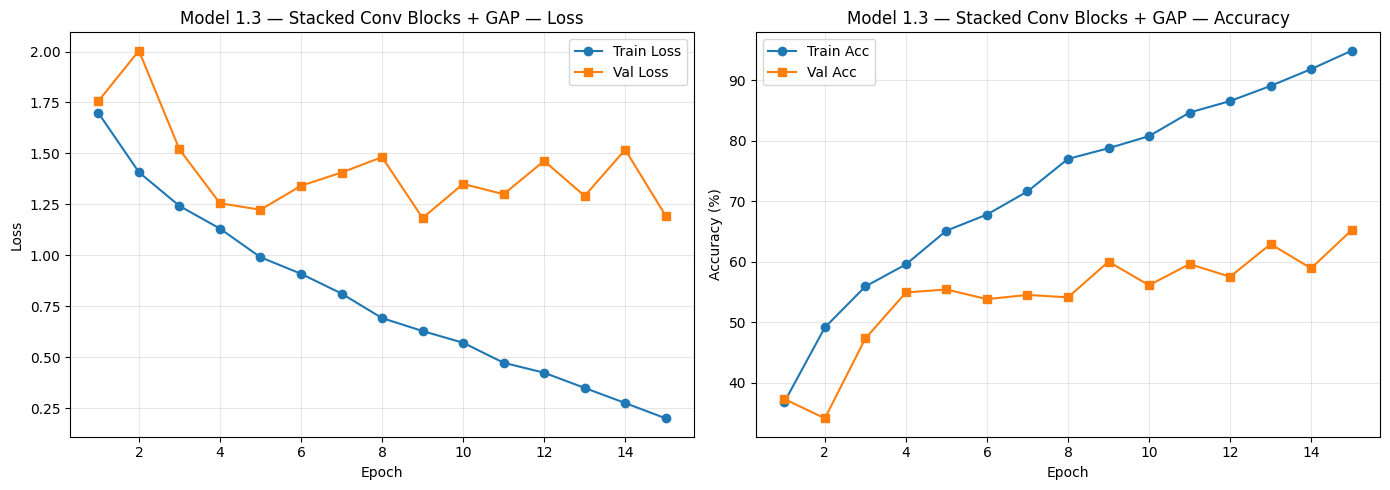

In [84]:
plot_history(history, title='Model 1.3 — Stacked Conv Blocks + GAP')

### 2.4 Results Summary

In [85]:
final_train_acc = history['train_acc'][-1]
final_val_acc   = history['val_acc'][-1]
peak_val_acc    = max(history['val_acc'])
gap             = final_train_acc - final_val_acc

print('=' * 50)
print('   MODEL 1.3 — RESULTS SUMMARY (Stacked Conv Blocks)')
print('=' * 50)
print(f'  Parameters       : {count_parameters(model):,}')
print(f'  Final Train Acc  : {final_train_acc:.2f}%')
print(f'  Final Val Acc    : {final_val_acc:.2f}%')
print(f'  Peak Val Acc     : {peak_val_acc:.2f}%')
print(f'  Train-Val Gap    : {gap:+.2f}%')
print(f'  Final Train Loss : {history["train_loss"][-1]:.4f}')
print(f'  Final Val Loss   : {history["val_loss"][-1]:.4f}')
print(f'  Diagnosis      : Best val accuracy so far — stacked 2×conv blocks extract richer features, but 30% gap shows regularisation is still needed.')
print('=' * 50)

   MODEL 1.3 — RESULTS SUMMARY (Stacked Conv Blocks)
  Parameters       : 289,194
  Final Train Acc  : 94.86%
  Final Val Acc    : 65.20%
  Peak Val Acc     : 65.20%
  Train-Val Gap    : +29.66%
  Final Train Loss : 0.2004
  Final Val Loss   : 1.1942
  Diagnosis      : Best val accuracy so far — stacked 2×conv blocks extract richer features, but 30% gap shows regularisation is still needed.
